In [1]:
import pandas as pd

# Setup

## Store data from csv to dataframes

In [2]:
demo = pd.read_csv('/content/drive/MyDrive/uidai/combined_dataset2/demo_combined.csv')
bio = pd.read_csv('/content/drive/MyDrive/uidai/combined_dataset2/bio_combined.csv')
enroll = pd.read_csv('/content/drive/MyDrive/uidai/combined_dataset2/enroll_combined.csv')

Update the links above where the combined datasets are stored

## Format the dates

In [3]:
demo['date'] = pd.to_datetime(demo['date'], format='%d-%m-%Y')
bio['date'] = pd.to_datetime(bio['date'], format='%d-%m-%Y')
enroll['date'] = pd.to_datetime(enroll['date'], format='%d-%m-%Y')

# Merging CSVs

In [4]:
key_cols = ["date", "state", "district", "pincode"]

**Date, District & Pincode**, combined are unique to a row of all datasets. State is also considered here for easy visualisations

(Date and Pincode alone are not sufficient, one pincode might appear in multiple districts)

## Create groups on key columns with sum as aggregation function

In [5]:
demo_group = demo.groupby(key_cols, as_index=False)[["demo_age_5_17", "demo_age_17_"]].sum()
bio_group = bio.groupby(key_cols, as_index=False)[["bio_age_5_17", "bio_age_17_"]].sum()
enroll_group = enroll.groupby(key_cols, as_index=False)[["age_0_5", "age_5_17", "age_18_greater"]].sum()

## Merge with key columns as key, and outer join

In [6]:
df = demo_group.merge(bio_group, on=key_cols, how='outer').merge(enroll_group, on=key_cols, how='outer')
df.sample(3)

,date,state,district,pincode,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_,age_0_5,age_5_17,age_18_greater
718238,2025-10-16,kerala,Kannur,670331,2.0,8.0,0.0,1.0,NaN,NaN,NaN
1162059,2025-11-05,haryana,Kurukshetra,136020,NaN,NaN,0.0,1.0,NaN,NaN,NaN
1538111,2025-11-25,kerala,Thrissur,680702,0.0,3.0,NaN,NaN,1.0,0.0,0.0


## Fill NaN with zero
Joining will introduce NaNs where one action occured and another action did not occur, we need to replace those NaN with 0

In [7]:
numeric_cols = ["demo_age_5_17", "demo_age_17_", "bio_age_5_17", "bio_age_17_", "age_0_5", "age_5_17", "age_18_greater"]

In [8]:
df[numeric_cols] = df[numeric_cols].fillna(0).astype(int)
df.sample(3)

,date,state,district,pincode,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_,age_0_5,age_5_17,age_18_greater
1223321,2025-11-07,rajasthan,Sirohi,307001,4,28,10,11,1,2,0
62996,2025-05-01,uttar pradesh,Farrukhabad,207502,0,0,247,127,0,0,0
226680,2025-09-05,uttar pradesh,Saharanpur,247121,4,57,3,4,0,0,0


## Running some checks
Check the following (below code cell will throw error if fails):

1. Date has no null values
2. District has no null values
3. Pincode has no null values
4. (date, district, pincode) combined does not repeat

In [9]:
assert df["date"].notna().all() #1
assert df["district"].notna().all() #2
assert df["pincode"].notna().all() #3
assert not df.duplicated(subset=["date","state", "district", "pincode"]).any() #4

If there's no error above, we are good to go!

In [10]:
df.to_csv('merged.csv')

# EDA (Exploratory Data Analysis)

In [11]:
# @title ### Unique Values in Each column
df.nunique()

,0
date,115
state,36
district,1021
pincode,19814
demo_age_5_17,756
demo_age_17_,3196
bio_age_5_17,2122
bio_age_17_,2214
age_0_5,671
age_5_17,624


In [12]:
# @title Are there any instances when all the columns had an update
isAllUpdated = (df[numeric_cols] > 0).all(axis=1)
len(df[isAllUpdated])


9886

Yes. There are 9886 instances

## Setting Up Visualization tools

In [13]:
import matplotlib.pyplot as plt
import geopandas as gpd
map_geojson = "/content/drive/MyDrive/uidai/INDIA_STATES.geojson"

### Helper Functions for map visualization

List of all states

In [14]:
all_states = df["state"].unique()

State Map Plotter

In [15]:
def plotStateMap(data, col, title, colorScheme="jet"):
  india_map = gpd.read_file(map_geojson)
  india_map["state"] = india_map["STNAME"].str.lower().str.strip()
  india_merged = india_map.merge(data, on="state", how="left")

  fig, ax = plt.subplots(figsize=(8, 10))
  india_merged.plot(column=col,
                    cmap=colorScheme, linewidth=0.6, edgecolor="black",
                    legend=True, ax=ax
                  )
  ax.set_title(title, fontsize=14)
  ax.axis("off")
  ax.ticklabel_format(style="plain", axis="y")
  plt.show()

Bar Plot

In [16]:
def plot_bar(data, x_col=None, y_col=None, title="", xlabel="", ylabel="", horizontal=False, top_n=None, color=None):

    if x_col is None and y_col is None:
        data = data.sort_values(ascending=False)
        if top_n is not None:
            data = data.head(top_n)
        x = data.index
        y = data.values
    else:
        data = data.copy()
        if top_n is not None:
            data = data.sort_values(y_col, ascending=False).head(top_n)
        x = data[x_col]
        y = data[y_col]

    plt.figure(figsize=(10, 6))

    if horizontal:
        plt.barh(x, y, color=color)
        plt.gca().invert_yaxis()
    else:
        plt.bar(x, y, color=color)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

### Feature Engineering

#### Action Columns

In [17]:
df["total_demo_updates"] = df["demo_age_5_17"] + df["demo_age_17_"]
df["total_bio_updates"] = df["bio_age_5_17"] + df["bio_age_17_"]
df["total_enrolments"] = df["age_0_5"] + df["age_5_17"] + df["age_18_greater"]

df["total_activity"] = df["total_demo_updates"] + df["total_bio_updates"] + df["total_enrolments"]
df["total_activity_lakh"] = df["total_activity"]/1e5

Activity Type: 0,1,2 for enrolments, biometric update and demographic update , -1 if no activity on that day

In [18]:
df["activity_type"] = df[["total_demo_updates", "total_bio_updates", "total_enrolments"]].idxmax(axis=1)
activity_map = {
    "total_enrolments": 0,
    "total_bio_updates": 1,
    "total_demo_updates": 2
}

df["activity_type"] = df["activity_type"].map(activity_map)
df.loc[ (df["total_enrolments"] == 0) & (df["total_bio_updates"] == 0) & (df["total_demo_updates"] == 0), "activity_type"] = -1

Temoporal Columns

In [19]:
df["date"] = pd.to_datetime(df["date"])
df["day"] = df["date"].dt.day
df["day_of_week"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month

### New groups

#### Total Activity in the states

In [20]:
state_totals = df.groupby("state", as_index=False)["total_activity"].sum()
state_totals = state_totals.sort_values(by="total_activity", ascending =False)
state_totals.head()

,state,total_activity
33,uttar pradesh,19138692
20,maharashtra,14649880
4,bihar,10321522
19,madhya pradesh,9330679
28,rajasthan,7161028


In [21]:
district_totals = df.groupby("district")[["total_enrolments","total_demo_updates","total_bio_updates"]].sum().reset_index()
district_totals["total_updates"] = district_totals["total_demo_updates"] + district_totals["total_bio_updates"]

Total Activity in the states (in lakhs)

In [22]:
state_totals_per_lakh = state_totals_per_lakh = state_totals.assign(total_activity_lakh=lambda x: x["total_activity"] / 1e5).reset_index()
state_totals_per_lakh.head(5)

,index,state,total_activity,total_activity_lakh
0,33,uttar pradesh,19138692,191.38692
1,20,maharashtra,14649880,146.49880
2,4,bihar,10321522,103.21522
3,19,madhya pradesh,9330679,93.30679
4,28,rajasthan,7161028,71.61028


#### No Activity Days in States

In [23]:
no_activity_instances = df[df["activity_type"] == -1]
no_activity_states = no_activity_instances.groupby("state").size().reindex(all_states, fill_value=0)
no_activity_states = no_activity_states.sort_values(ascending=False)
no_activity_states = no_activity_states.reset_index().rename(columns={0: "no_activity_days"})
no_activity_states.head()

,state,no_activity_days
0,andhra pradesh,251
1,karnataka,88
2,tamil nadu,63
3,west bengal,52
4,himachal pradesh,25


In [24]:
state_type = (
    df.groupby("state")["activity_type"]
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index(name="state_type")
)
state_type["state_type"] = state_type["state_type"].map({
    0: "Enrolment Heavy",
    1: "Biometric Heavy",
    2: "Demographic Heavy"
})
state_type.head()

,state,state_type
0,andaman & nicobar,Biometric Heavy
1,andhra pradesh,Demographic Heavy
2,arunachal pradesh,Demographic Heavy
3,assam,Demographic Heavy
4,bihar,Demographic Heavy


In [25]:
state_activity = (df.groupby("state")[["total_enrolments","total_demo_updates","total_bio_updates"]]
                  .sum().sort_values(by=["total_enrolments", "total_demo_updates", "total_bio_updates"],
                                     ascending=False
                                    )
                 )
state_activity = state_activity.reset_index()
state_activity["updates"] = state_activity["total_demo_updates"] + state_activity["total_bio_updates"]
state_activity.head()

,state,total_enrolments,total_demo_updates,total_bio_updates,updates
0,uttar pradesh,1018629,8542328,9577735,18120063
1,bihar,609585,4814350,4897587,9711937
2,madhya pradesh,493970,2912938,5923771,8836709
3,west bengal,375340,3872737,2524619,6397356
4,maharashtra,369139,5054602,9226139,14280741


In [26]:
top_10_states = state_activity.head(10)["state"]
bottom_10_states = state_activity.tail(10)["state"]

In [27]:
district_daily = df.groupby(["district", "date"])["total_activity"].sum().reset_index()

district_stats = district_daily.groupby("district")["total_activity"].agg(["mean", "std"]).reset_index()
district_stats = district_stats.rename(columns={"mean": "mean_activity","std": "std_activity"})

In [28]:
presence = df.assign(active=(df["activity_type"] != -1).astype(int)).pivot_table(
          index="state",
          columns="date",
          values="active",
          aggfunc="max",
          fill_value=0
      )
presence = presence.sort_index(axis=1)
presence.head()

date,2025-03-01,2025-03-02,2025-03-09,2025-03-15,2025-03-20,2025-03-23,2025-03-26,2025-03-27,2025-03-28,2025-03-29,...,2025-12-21,2025-12-22,2025-12-23,2025-12-24,2025-12-25,2025-12-26,2025-12-27,2025-12-28,2025-12-29,2025-12-31
state,,,,,,,,,,,,,,,,,,,,,
andaman & nicobar,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
andhra pradesh,1,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
arunachal pradesh,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
assam,1,0,0,1,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
bihar,1,0,1,1,1,1,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1


In [29]:
state_month_type = (df[df["activity_type"] != -1].groupby(["state", "month"])["activity_type"]
    .agg(lambda x: x.value_counts().idxmax()).reset_index(name="dominant_type")
)

assert "activity_type" in df.columns

transition_matrix = (
    state_month_type
    .pivot(index="state", columns="month", values="dominant_type")
    .sort_index(axis=1)
)

In [30]:
daily_activity = df.groupby("date")["total_activity"].sum().sort_index()

# Visualisations

## Total Actions (Demographic Updates + Biometric Updates + Enrolments) in Lakhs

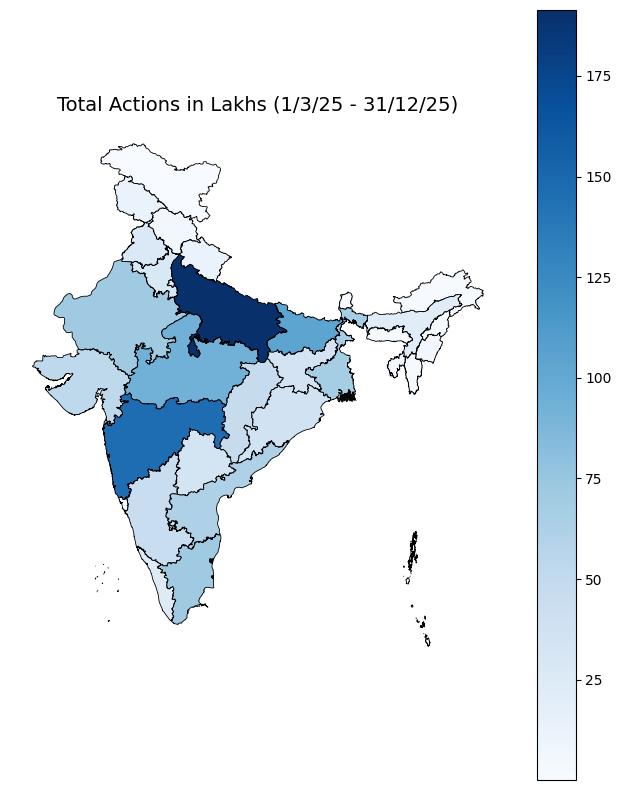

In [31]:
plotStateMap(state_totals_per_lakh, 'total_activity_lakh', "Total Actions in Lakhs (1/3/25 - 31/12/25)", "Blues")

## No. of No Activity Days during the time period

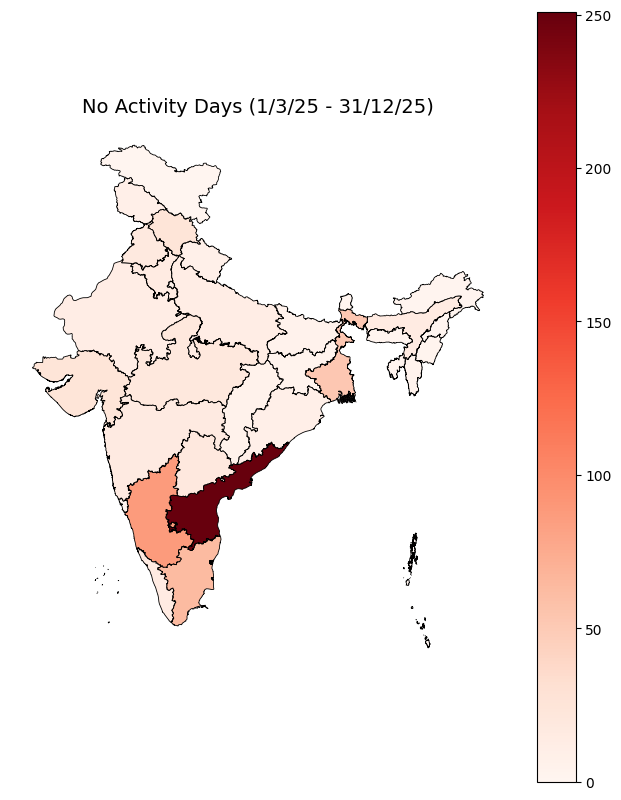

In [32]:
plotStateMap(no_activity_states, "no_activity_days", "No Activity Days (1/3/25 - 31/12/25)", colorScheme="Reds")

## Dominant Aadhaar Service Type Across States

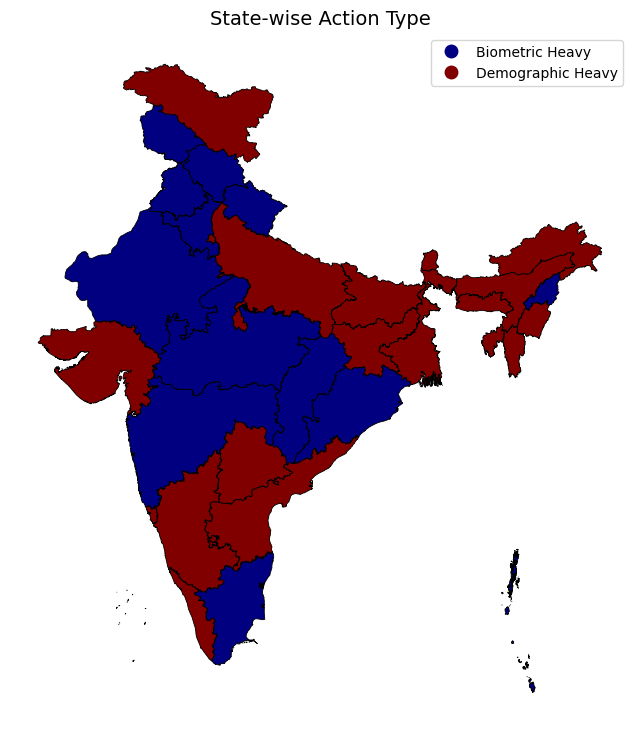

In [33]:
plotStateMap(state_type, "state_type", "State-wise Action Type", colorScheme="jet")

## State Wise Aadhaar Activity Presence by day

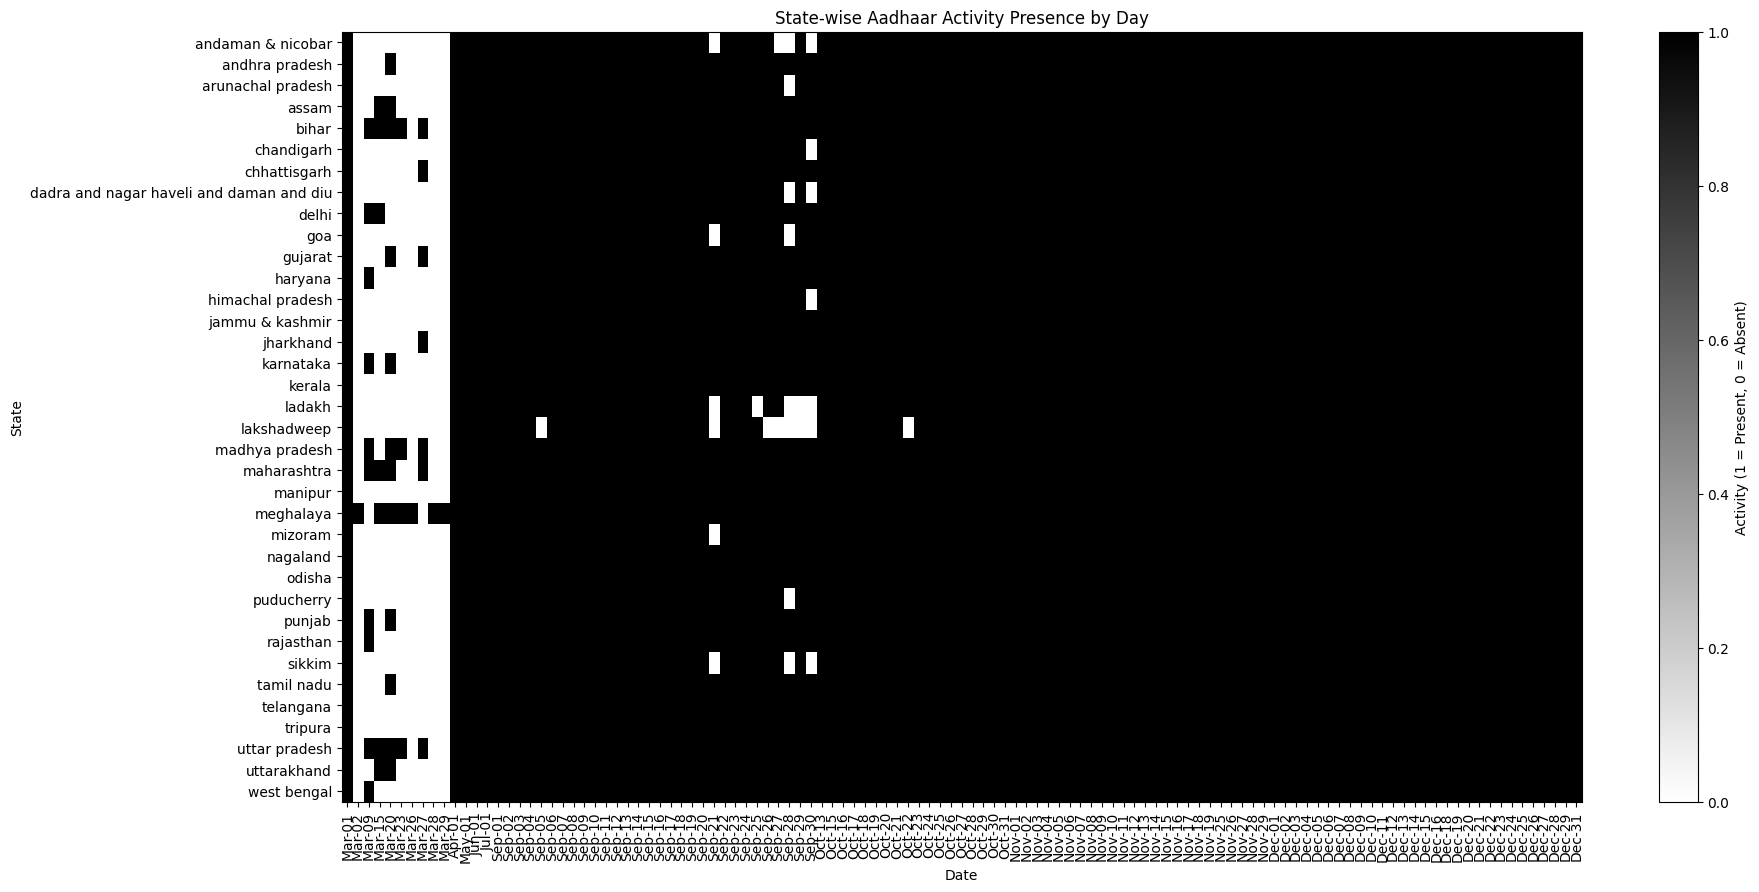

In [34]:
# @title
import matplotlib.pyplot as plt
dates = presence.columns
plt.figure(figsize=(20, 10))
plt.imshow(presence, aspect="auto", cmap="grey_r")
plt.colorbar(label="Activity (1 = Present, 0 = Absent)")
month_periods = dates.to_period("M")
month_start_mask = month_periods != month_periods.shift()
tick_positions = [i for i, v in enumerate(month_start_mask) if v]
tick_labels = dates[month_start_mask].strftime("%b-%d")

plt.xticks(tick_positions, tick_labels, rotation=90)
plt.yticks(range(len(presence.index)), presence.index)
plt.xlabel("Date")
plt.ylabel("State")
plt.title("State-wise Aadhaar Activity Presence by Day")

plt.show()

## Temporal Patterns of Aadhaar Activity Dominance by State

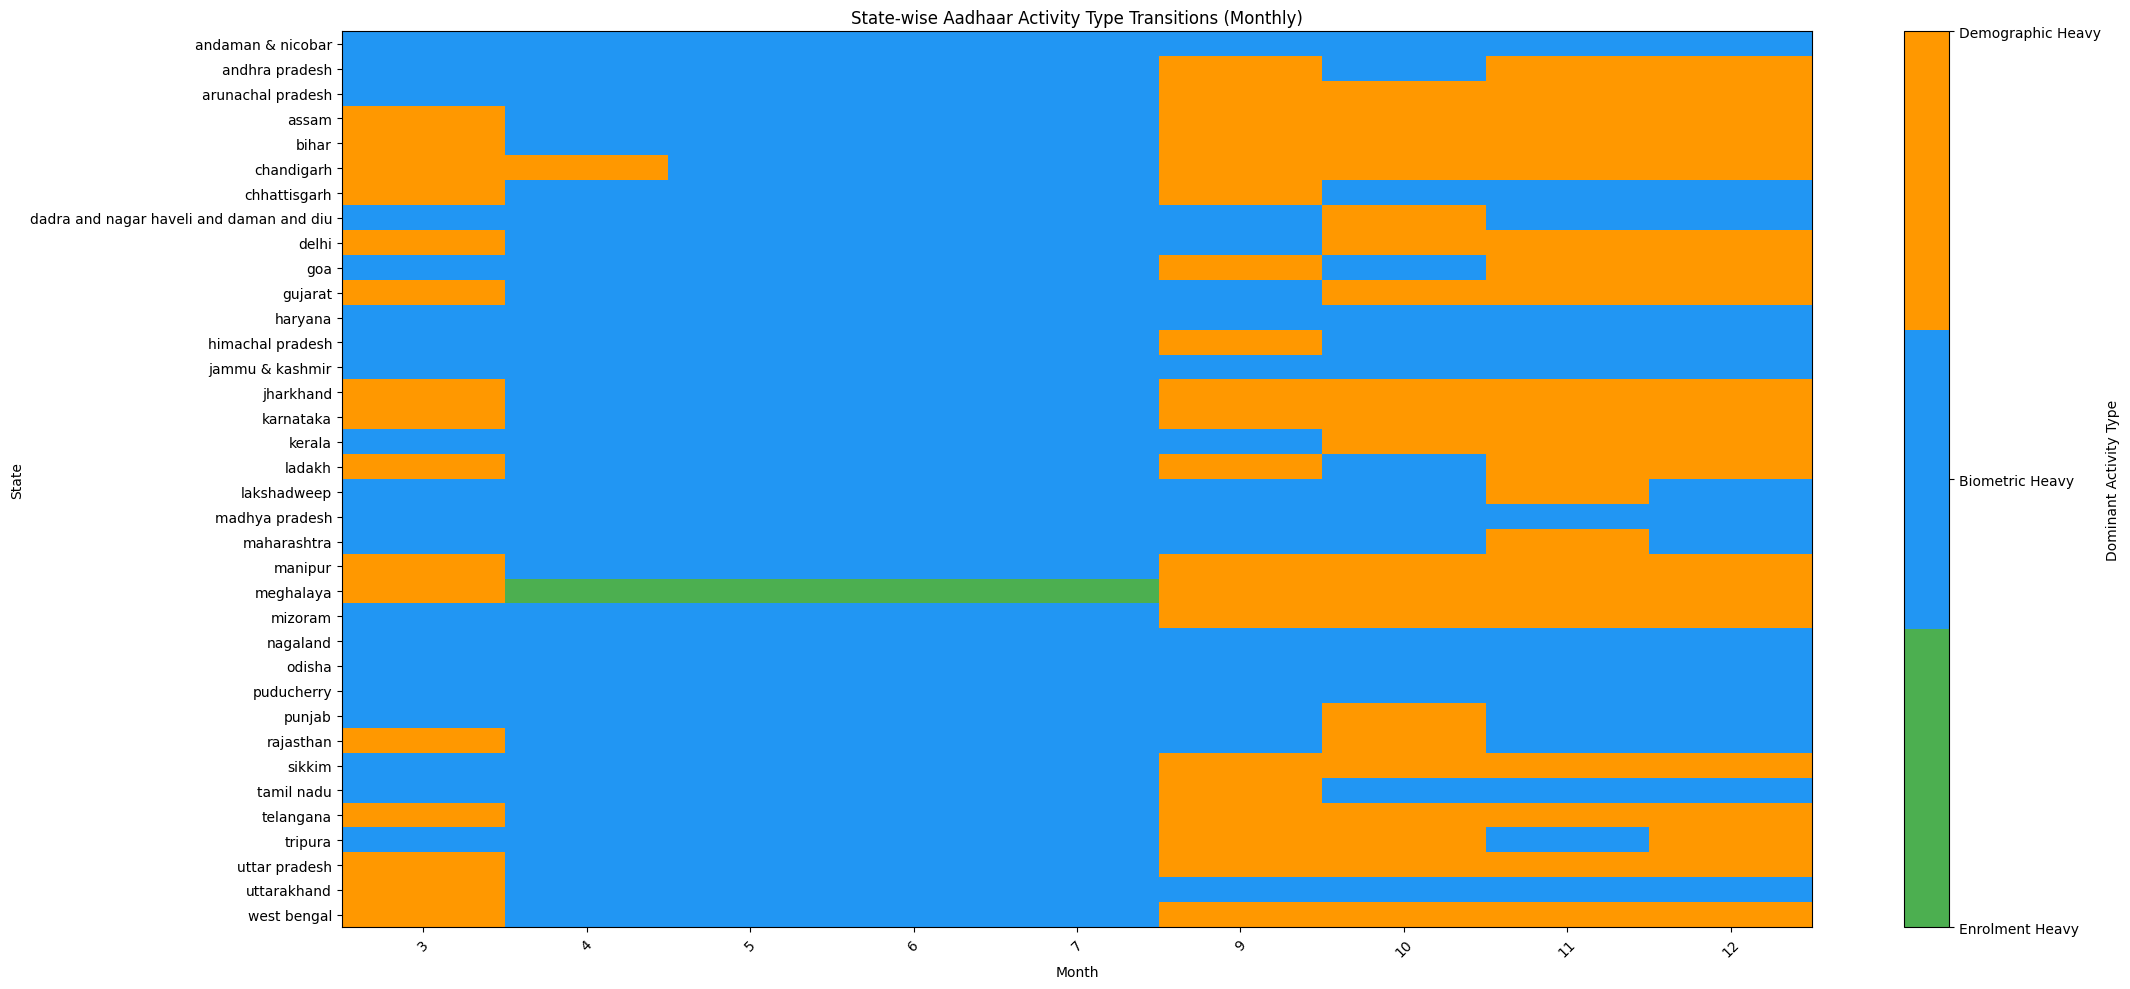

In [35]:
# @title
from matplotlib.colors import ListedColormap

cmap = ListedColormap(["#4CAF50","#2196F3","#FF9800"])

plt.figure(figsize=(22, 10))
plt.imshow(transition_matrix, aspect="auto", cmap=cmap)

plt.yticks(range(len(transition_matrix.index)), transition_matrix.index)
plt.xticks(range(len(transition_matrix.columns)), transition_matrix.columns.astype(str), rotation=45)

plt.xlabel("Month")
plt.ylabel("State")
plt.title("State-wise Aadhaar Activity Type Transitions (Monthly)")

cbar = plt.colorbar(ticks=[0, 1, 2], label="Activity Type")
cbar.ax.set_yticklabels(["Enrolment Heavy", "Biometric Heavy", "Demographic Heavy"])
cbar.set_label("Dominant Activity Type")

plt.tight_layout()
plt.show()

Top 10 States by No Activity Days

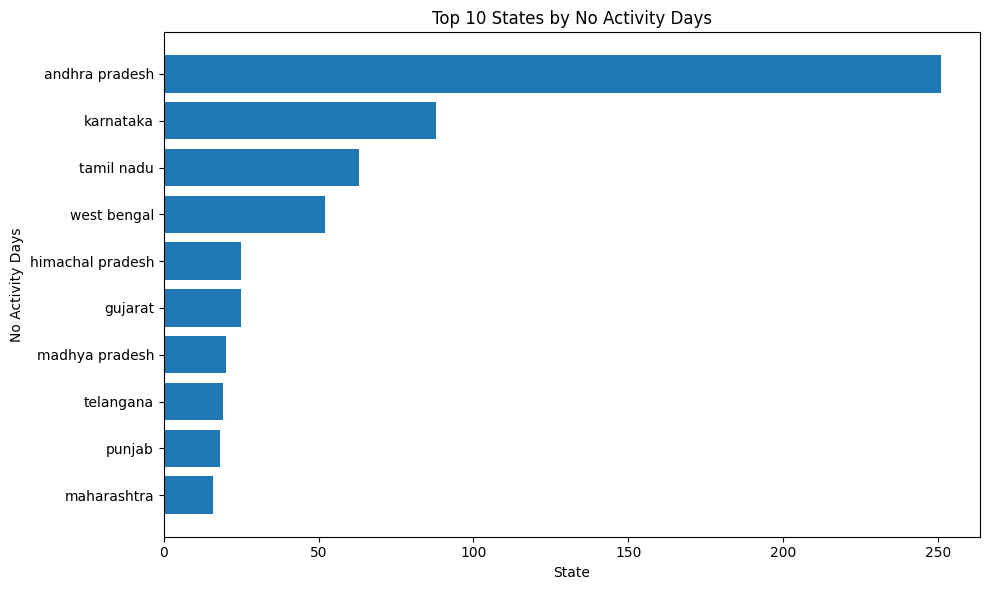

In [36]:
plot_bar(no_activity_states,x_col='state', y_col='no_activity_days', title="Top 10 States by No Activity Days", xlabel="State", ylabel="No Activity Days", horizontal=True, top_n=10)

State wise Aadhaar Action Composition

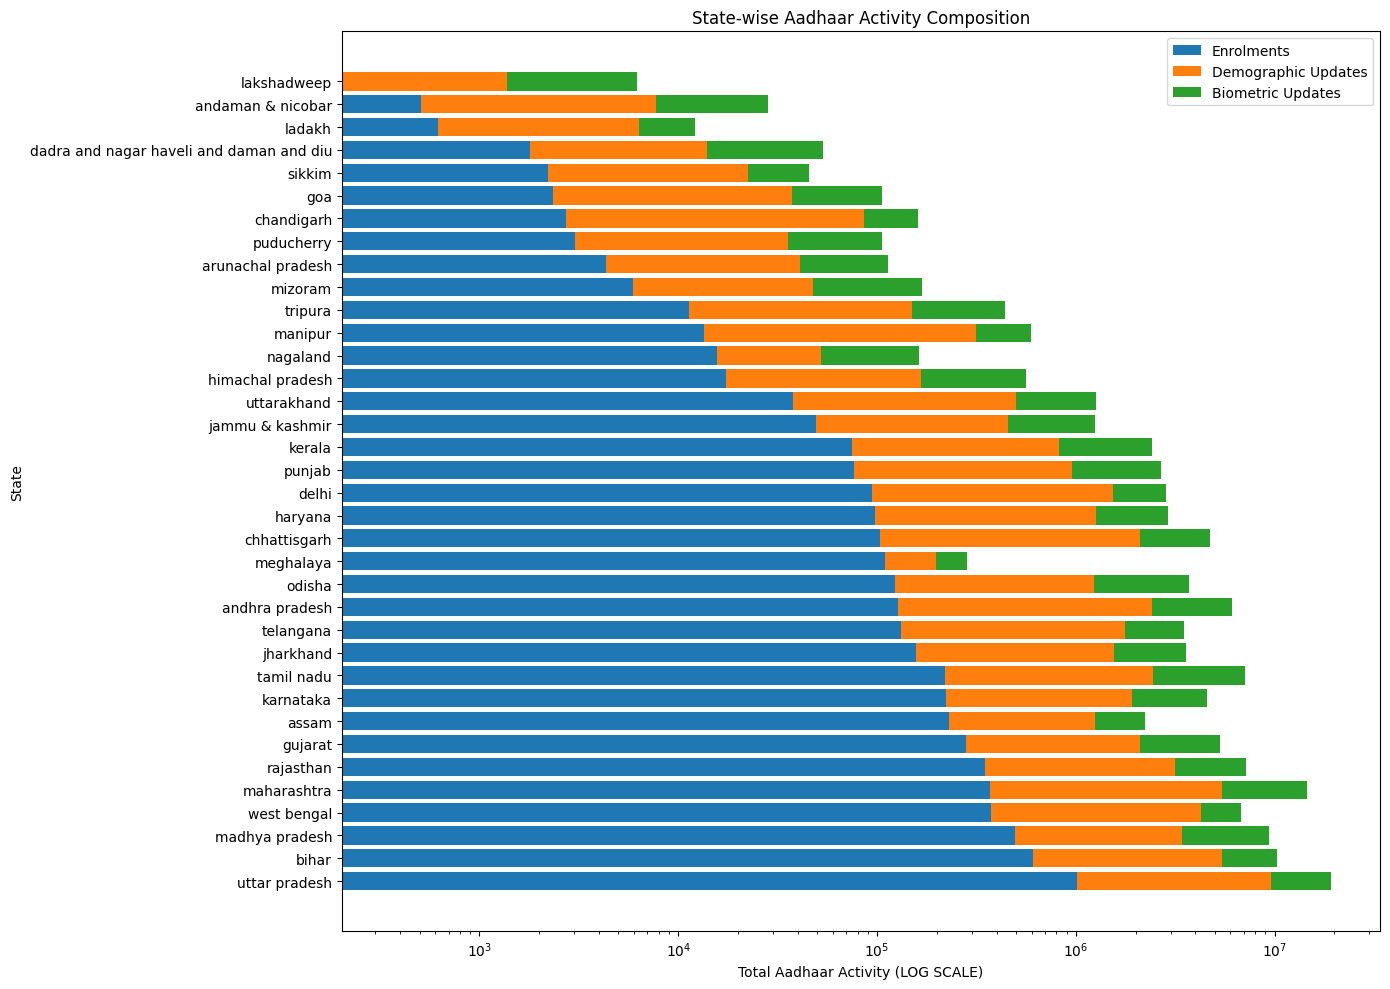

In [37]:
# @title
plt.figure(figsize=(14, 10))

plt.barh(state_activity['state'], state_activity["total_enrolments"], label="Enrolments")
plt.barh(state_activity['state'], state_activity["total_demo_updates"], left=state_activity["total_enrolments"], label="Demographic Updates")
plt.barh(state_activity['state'], state_activity["total_bio_updates"], left=state_activity["total_enrolments"] + state_activity["total_demo_updates"], label="Biometric Updates")

plt.xscale("log")
plt.xlabel("Total Aadhaar Activity (LOG SCALE)")
plt.ylabel("State")
plt.title("State-wise Aadhaar Activity Composition")

plt.legend()
plt.tight_layout()
plt.show()

## Daily Total Aadhaar activity Across India

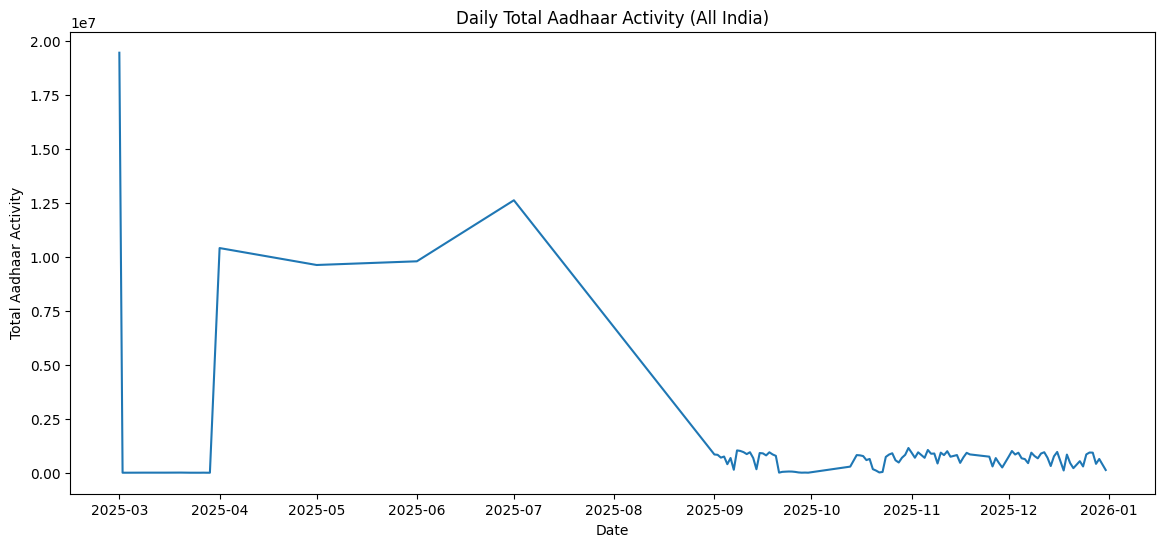

In [38]:
# @title
plt.figure(figsize=(14, 6))
plt.plot(daily_activity.index, daily_activity.values)

plt.xlabel("Date")
plt.ylabel("Total Aadhaar Activity")
plt.title("Daily Total Aadhaar Activity (All India)")

plt.show()

## Interactive Scatterplot of Districts' Daily Total Activity Mean v/s Std

In [39]:
# @title
import plotly.express as px

fig = px.scatter(
    district_stats,
    x="mean_activity",
    y="std_activity",
    hover_name="district",
    labels={
        "mean_activity": "Mean Daily Activity",
        "std_activity": "Activity Volatility (Std Dev)"
    },
    title="District Behaviour: Activity Level vs Volatility"
)

fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.show()

## Interactive Scatterplot of Districts' Total Enrolments vs Total Updates

In [40]:
# @title
fig = px.scatter(
    district_totals,
    x="total_enrolments",
    y="total_updates",
    hover_name="district",
    labels={
        "total_enrolments": "Total Enrolments",
        "total_updates": "Total Updates"
    },
    title="District Behaviour: Enrolments vs Updates"
)

fig.show()

## Interactive Sunburst of Top 10 and Bottom 10 States' Update Composition

In [41]:
sunburst_base = pd.concat([
    state_activity[["state", "total_bio_updates"]].rename(columns={"total_bio_updates": "value"}).assign(activity="Biometric Updates"),
    state_activity[["state", "total_demo_updates"]].rename(columns={"total_demo_updates": "value"}).assign(activity="Demographic Updates")
])
sunburst_base = sunburst_base[sunburst_base["value"] > 0]

sunburst_top10 = sunburst_base[sunburst_base["state"].isin(top_10_states)]
sunburst_bottom10 = sunburst_base[sunburst_base["state"].isin(bottom_10_states)]

In [42]:
# @title
from plotly.subplots import make_subplots
fig_top = px.sunburst(sunburst_top10, path=["state", "activity"], values="value", color="state", title="Top 10 States: Aadhaar Update Composition")
fig_top.update_traces( textinfo="label+percent parent", insidetextorientation="radial", marker=dict(line=dict(color="white", width=1)))
fig_bottom = px.sunburst(sunburst_bottom10, path=["state", "activity"], values="value", color="state", title="Bottom 10 States: Aadhaar Update Composition")
fig_bottom.update_traces( textinfo="label+percent parent", insidetextorientation="radial", marker=dict(line=dict(color="white", width=1)))

fig = make_subplots(rows=1, cols=2,
    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]],
    subplot_titles=["Top 10 States: Aadhaar Update Composition", "Bottom 10 States: Aadhaar Update Composition"]
)

fig.add_trace(fig_top.data[0], row=1, col=1)
fig.add_trace(fig_bottom.data[0], row=1, col=2)

fig.update_layout(height=650, showlegend=False, margin=dict(t=60, l=0, r=0, b=0))
fig.show()